In [1]:
import json
import pandas as pd
import os
import copy
from pathlib import Path
import sys
sys.path.append("/home/dguittet/ThermalTank")
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from thermal_tank.tank_bypass_branch import TankBypassBranch, OpMode
from thermal_tank.mpc import *


controls_path = Path().resolve()
mpc_init_path =  controls_path / "schedules_mdoff" / "coned" / "mpc_forecast_states.parquet"

In [38]:
start_date = pd.Timestamp('2019-01-01 00:01:00')

ix = pd.date_range(start=start_date, 
                    end=start_date
                    + pd.offsets.DateOffset(days=365)
                    - pd.offsets.DateOffset(seconds=60),
                    freq='60s')
ix = ix[(ix.day != 29) | (ix.month != 2)]
evaps_df = pd.DataFrame(index=ix)

for n in range(1, 8):
    n_tanks = n
    thermal_tank_log_dir = controls_path / "schedules_mdoff" / "coned" / f"{n_tanks}tanks"
    df = pd.read_parquet(thermal_tank_log_dir / "eplusout.parquet")
    assert n_tanks == df['NUM TANKS:Schedule Value [](TimeStep)'].unique()[0]
    evaps_df["loop_inlet_" + str(n)] = loop_inlet = df['CHW LOOP CHILLER:Chiller Evaporator Inlet Temperature [C](TimeStep)'].values
    evaps_df["chiller_outlet_" + str(n)] = df['CHW LOOP CHILLER:Chiller Evaporator Outlet Temperature [C](TimeStep)'].values
    evaps_df["loop_outlet_" + str(n)] = loop_outlet = df['t_tank_out:PythonPlugin:OutputVariable [](TimeStep)'].values
    evaps_df["evap_diff_" + str(n)] = [loop_inlet[i+1] - loop_outlet[i] for i in range(0, len(df) - 1)] + [loop_inlet[0] - loop_outlet[len(df) - 1]]
    evaps_df['chiller_p_' + str(n)] = df['CHW LOOP CHILLER:Chiller Electricity Energy [J](TimeStep)'].values / 60 / 1000
    pv_load = np.zeros(len(loop_inlet)) 
    if 'PV LOAD CENTER:Electric Load Center Supplied Electricity Rate [W](TimeStep)' in df.columns:
        pv_load = df['PV LOAD CENTER:Electric Load Center Supplied Electricity Rate [W](TimeStep)'].values
    evaps_df['bldg_elec_p_' + str(n)] = ((df['Electricity:Facility [J](TimeStep)'] 
                                         - df['CHW LOOP CHILLER:Chiller Electricity Energy [J](TimeStep)']
                                         - df['EVLoad:ExteriorEquipment:Electricity [J](TimeStep)']).values / 60 
                                        ) * 1e-3
    evaps_df['soc_' + str(n)] = df['soc:PythonPlugin:OutputVariable [](TimeStep)'].values
evaps_df["cond_inlet"] = df['CHW LOOP CHILLER:Chiller Condenser Inlet Temperature [C](TimeStep)'].values


,pv_kw
Date/Time,
2019-01-01 00:00:00,0.0
2019-01-01 00:15:00,0.0
2019-01-01 00:30:00,0.0
2019-01-01 00:45:00,0.0
2019-01-01 01:00:00,0.0
...,...
2019-01-01 22:45:00,0.0
2019-01-01 23:00:00,0.0
2019-01-01 23:15:00,0.0


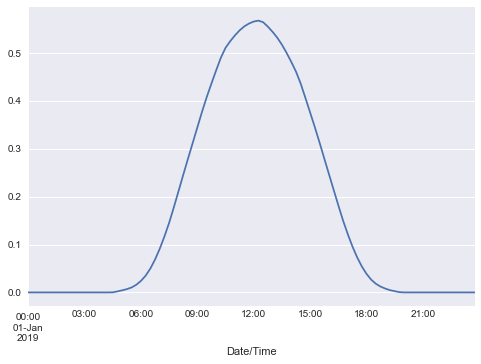

In [40]:
df = pd.read_parquet("/Users/dguittet/Projects/EnStore/EnStore/test_files/fcntr3/base/003/eplusout.parquet")
pv_df = pd.DataFrame(df.resample("15min").mean()["PV LOAD CENTER:Electric Load Center Produced Electricity Rate [W](TimeStep)"])
pv_df["pv_kw"] = pv_df['PV LOAD CENTER:Electric Load Center Produced Electricity Rate [W](TimeStep)'] * 1e-3
pv_df = pv_df.drop(columns=["PV LOAD CENTER:Electric Load Center Produced Electricity Rate [W](TimeStep)"])
pv_avg = pv_df["pv_kw"].values[0:8760 * 4].reshape((-1, 24*4)).mean(axis=0)
pv_df = pv_df[0:96]
pv_df['pv_kw'] = pv_avg
pv_df['pv_kw'].plot()
pv_df.to_parquet("/Users/dguittet/Projects/EnStore/ThermalTank/controls/schedules_mdoff/pv.parquet")
pv_df

Text(0.5, 0.98, 'EnergyPlus Simulated Electric Loads')

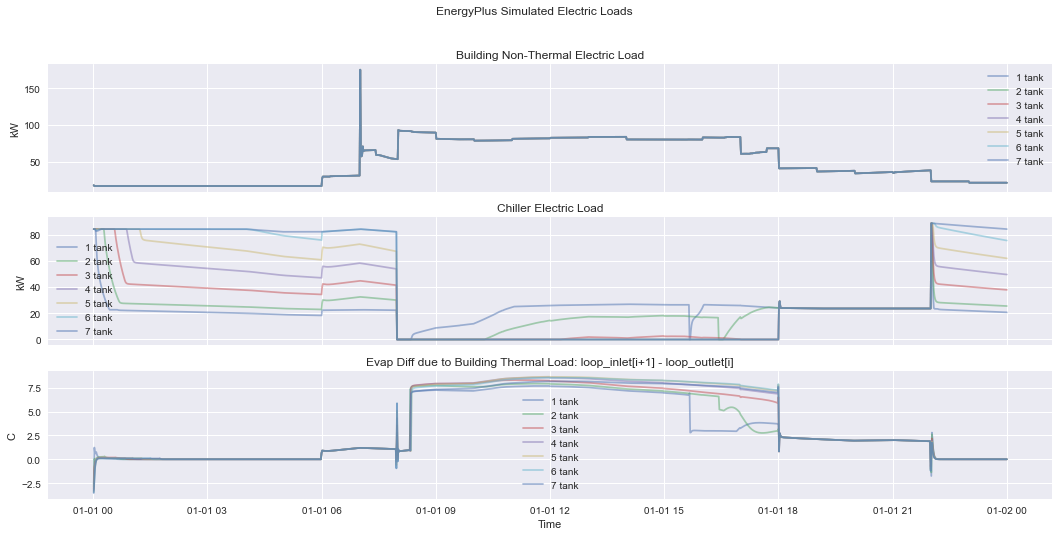

In [3]:
start = 1440 * 0
end = start + 1440 * 1
fig, ax = plt.subplots(3, 1, figsize=(18, 8), sharex=True)

for n in range(1, 8):
    ax[0].plot(evaps_df['bldg_elec_p_' + str(n)][start:end], label=f"{n} tank", alpha=0.5)
    ax[1].plot(evaps_df['chiller_p_' + str(n)][start:end], label=f"{n} tank", alpha=0.5)
    ax[2].plot(evaps_df["evap_diff_" + str(n)][start:end], label=f"{n} tank", alpha=0.5)

ax[0].legend()
ax[0].set_title("Building Non-Thermal Electric Load")
ax[0].set_ylabel("kW")
ax[1].legend()
ax[1].set_title("Chiller Electric Load")
ax[1].set_ylabel("kW")
ax[2].set_title("Evap Diff due to Building Thermal Load: loop_inlet[i+1] - loop_outlet[i]")
ax[2].legend()
ax[2].set_ylabel("C")
ax[2].set_xlabel("Time")
fig.suptitle("EnergyPlus Simulated Electric Loads")


# Fit a Building Load / Evaporator Difference Model

In [109]:
from scipy.stats import linregress

def reject_outliers(data, m=2):
    reject_filter = abs(data - np.mean(data)) < m * np.std(data)
    return data[reject_filter], reject_filter
    
# switch to Kelvin
slope_mean_preproc = -0.35705
slope_std_preproc = 0.49144
p_vals = []
build_load_func = []

# run for each minute: evap_diff_{t} = A_{t} * evap_diff_{t} + b_{t}
for i in range(8760 * 60):
    y = [evaps_df["evap_diff_" + str(n)][i] for n in range(1, 8)]
    x = [evaps_df["loop_outlet_" + str(n)][i] + 273.15 for n in range(1, 8)]
    y_mod, reject_filter = reject_outliers(np.array(y))
    if max(x) - min(x) < 2e-1:
        slope = 0
        if len(y_mod) == len(y) - 1:
            intercept = np.average(y_mod)
        else:
            intercept = np.average(y)
        p_vals.append(-1)
    elif len(y_mod) == len(y) - 1 and max(x) - min(x) < 5e-1:
        slope = 0
        intercept = np.average(y_mod)
        p_vals.append(-1)
    else:
        y_mod, reject_filter = reject_outliers(np.array(y), m=1.5)
        x_mod = [x[i] for i in reject_filter if i]
        if max(x_mod) - min(x_mod) < 2e-3:
            slope = 0
            intercept = np.average(y_mod)
            p = -1
        else:
            slope, intercept, r, p, se = linregress(x_mod, y_mod)
        if abs(slope - slope_mean_preproc) > 3 * slope_std_preproc:
            print(x, y, slope, intercept, y_mod)
            print(i)
            break
            slope = 0
            intercept = np.average(y)
            p = -1
        p_vals.append(p)
    build_load_func.append([slope, intercept])
build_load_func = np.array(build_load_func)


<ipython-input-109-8a3dc9475f6a>:31: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  x_mod = [x[i] for i in reject_filter if i]


630


Text(0.5, 0.98, 'Max Building Thermal Load Period')

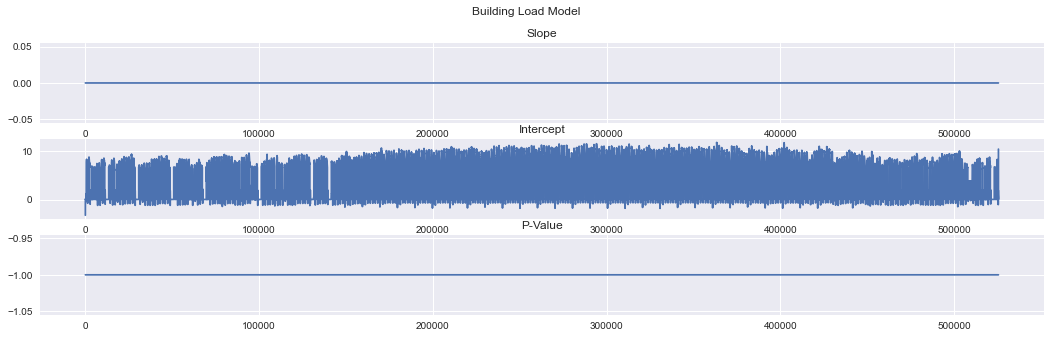

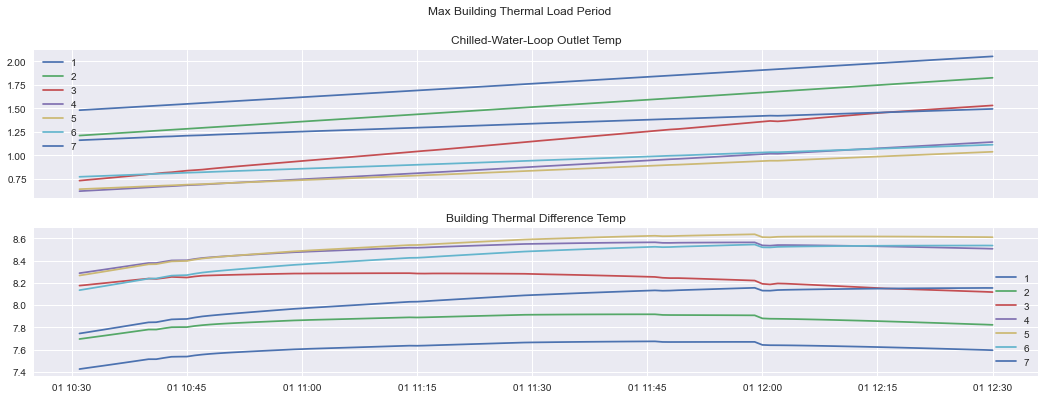

In [194]:
fig, ax = plt.subplots(3, 1, figsize=(18, 5))
fig.suptitle("Building Load Model")
ax[0].plot(build_load_func[:, 0], label="slopes")
ax[0].set_title("Slope")
ax[1].plot(build_load_func[:, 1], label="ints")
ax[1].set_title("Intercept")
ax[2].plot(range(len(p_vals)), p_vals)
ax[2].set_title("P-Value")

argmax = np.argmax(abs(build_load_func[:, 0]))
argmax = start - 60
print(argmax)

index = evaps_df.index[argmax:argmax+120]
fig, ax = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

x = [evaps_df["loop_outlet_" + str(n)][argmax] for n in range(1, 8)]
y = [evaps_df["evap_diff_" + str(n)][argmax] for n in range(1, 8)]
for n in range(1, 8):
    ax[0].plot(index, evaps_df["loop_outlet_" + str(n)][argmax:argmax + 120], label=n)
    ax[1].plot(index, evaps_df["evap_diff_" + str(n)][argmax:argmax + 120], label=n)
ax[0].legend()
ax[0].set_title("Chilled-Water-Loop Outlet Temp")
ax[1].legend()
ax[1].set_title("Building Thermal Difference Temp")
fig.suptitle("Max Building Thermal Load Period")


In [111]:
evaps_short = evaps_df.head(1441)
evaps_short.to_csv(controls_path / "schedules_mdoff" / "coned" / "mpc_forecast_states.csv")

## Fit smooth functions for avg-day building electric and thermal loads

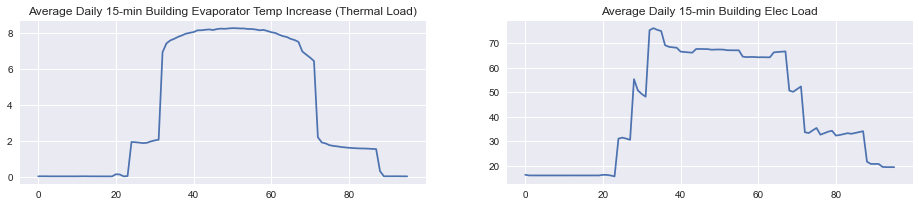

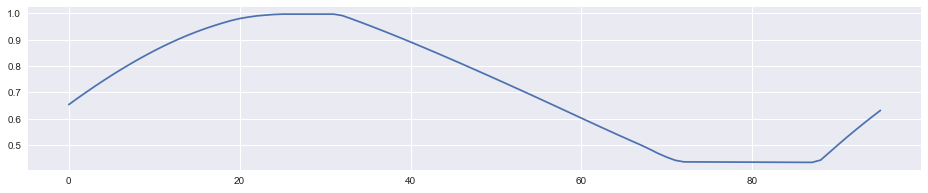

In [26]:
evaps_smooth = []
for n in range(1, 8):
    df = evaps_df[["evap_diff_" + str(n), "bldg_elec_p_" + str(n), "soc_" + str(n)]]
    df = df.rename(columns={"evap_diff_" + str(n): "evap_diff", 
                            "bldg_elec_p_" + str(n): "bldg_elec_p",
                            "soc_" + str(n): "soc"})
    df = df.resample('15min').mean()
    df['n_tanks'] = n
    evaps_smooth.append(df.head(-1))
evaps_smooth = pd.concat(evaps_smooth)

fig, ax = plt.subplots(1, 2, figsize=(16, 3), sharex=True)
avg_evaps = evaps_smooth['evap_diff'].values.reshape((-1, 35040)).mean(axis=0)
day_avg_evaps = avg_evaps.reshape((-1, 24*4)).mean(axis=0)
ax[0].plot(day_avg_evaps)
ax[0].set_title("Average Daily 15-min Building Evaporator Temp Increase (Thermal Load)")
avg_elec_p = evaps_smooth['bldg_elec_p'].values.reshape((-1, 35040)).mean(axis=0)
day_avg_elec_p = avg_elec_p.reshape((-1, 24*4)).mean(axis=0)
ax[1].plot(day_avg_elec_p)
ax[1].set_title("Average Daily 15-min Building Elec Load")


fig, ax = plt.subplots(1, 1, figsize=(16, 3), sharex=True)
avg_soc = evaps_smooth['soc'].values.reshape((-1, 35040)).mean(axis=0)
day_avg_soc = avg_soc.reshape((-1, 24*4)).mean(axis=0)
ax.plot(day_avg_soc)

In [27]:
day_avg_evaps, day_avg_elec_p, day_avg_soc

(array([0.01958495, 0.0228698 , 0.0209096 , 0.01862652, 0.01813963,
        0.0179887 , 0.01810211, 0.01836387, 0.0182178 , 0.01791511,
        0.01806415, 0.02163768, 0.02237922, 0.01887287, 0.01797238,
        0.01772058, 0.01745959, 0.01679734, 0.01591296, 0.01758565,
        0.13595109, 0.12124158, 0.01740975, 0.03590189, 1.93234826,
        1.92115984, 1.89758417, 1.87086505, 1.88954586, 1.96646219,
        2.02222588, 2.06206526, 6.93963399, 7.4301603 , 7.59840698,
        7.68613808, 7.79581187, 7.87832544, 7.97083929, 8.02110636,
        8.06276026, 8.15795459, 8.16423986, 8.19150465, 8.21035962,
        8.17779164, 8.2289084 , 8.25588023, 8.24388035, 8.26435807,
        8.28204934, 8.27559752, 8.26455661, 8.26263221, 8.23344797,
        8.23258895, 8.20486102, 8.16241734, 8.1839181 , 8.12272945,
        8.05531841, 8.01425641, 7.91807099, 7.83576764, 7.78822197,
        7.6824746 , 7.61855377, 7.51522441, 6.97922514, 6.80505296,
        6.63976008, 6.44683076, 2.19815378, 1.90

In [211]:
evaps_smooth_week = evaps_smooth[evaps_smooth.index<= evaps_smooth.index.values[int(60*4)*2]]

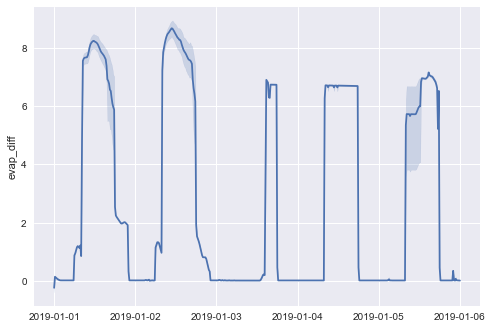

In [212]:
import seaborn as sns

sns.lineplot(x=evaps_smooth_week.index, y='evap_diff',
             data=evaps_smooth_week)


# Fit a Chiller Power Model

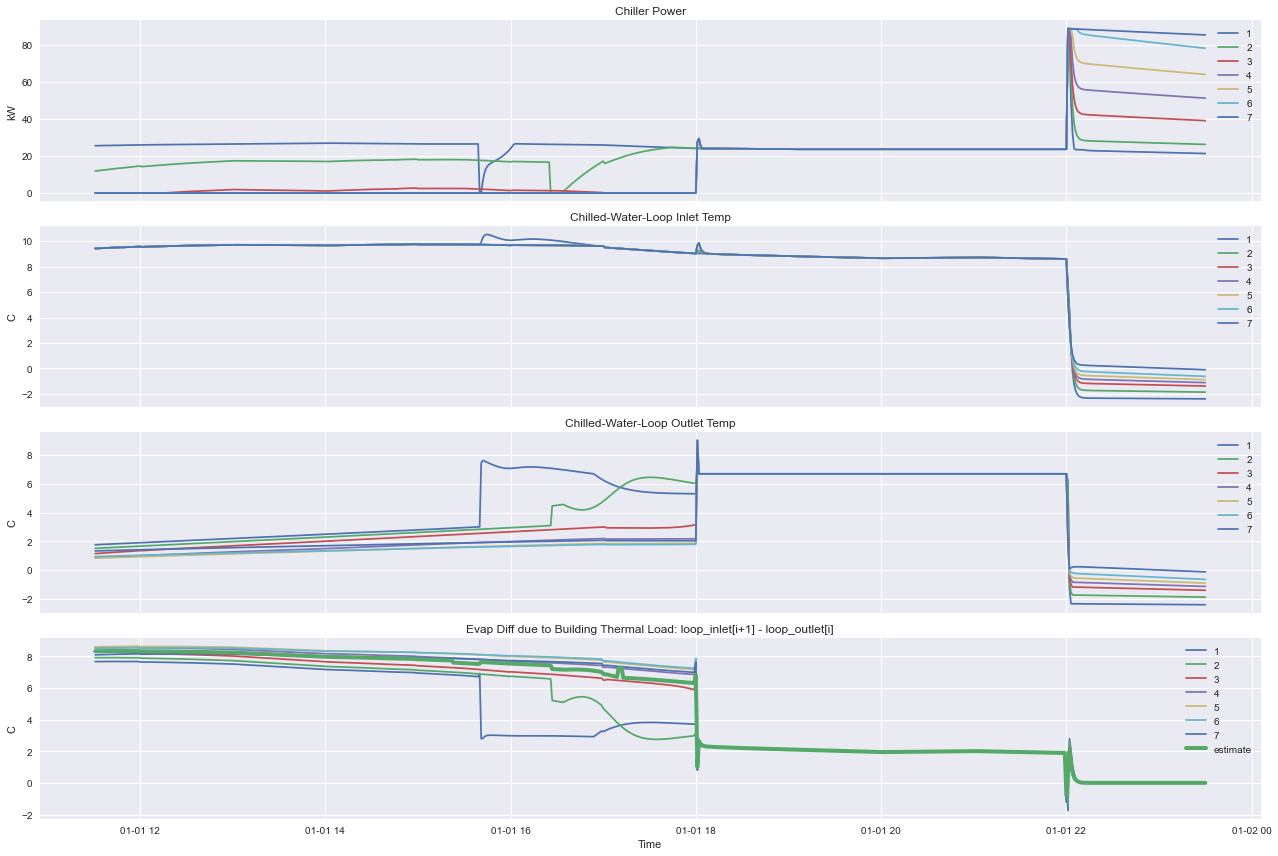

In [193]:
# start = 1440 * 202 + 17
ts = 1050
start = ts - 360
end = start + 360 * 2
fig, ax = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

for n in range(1, 8):
    ax[0].plot(evaps_df['chiller_p_' + str(n)][start:end], label=n)
    ax[1].plot(evaps_df["loop_inlet_" + str(n)][start:end], label=n)
    ax[2].plot(evaps_df["loop_outlet_" + str(n)][start:end], label=n)
    ax[3].plot(evaps_df["evap_diff_" + str(n)][start:end], label=n)

ax[0].set_title("Chiller Power")
ax[0].legend()
ax[0].set_ylabel("kW")

ax[1].set_title("Chilled-Water-Loop Inlet Temp")
ax[1].legend()
ax[1].set_ylabel("C")

ax[2].set_title("Chilled-Water-Loop Outlet Temp")
ax[2].legend()
ax[2].set_ylabel("C")

ax[3].plot(evaps_df.index[start:end], build_load_func[:, 1][start:end].tolist(), linewidth='4', label="estimate")
ax[3].set_title("Evap Diff due to Building Thermal Load: loop_inlet[i+1] - loop_outlet[i]")
ax[3].legend()
ax[3].set_ylabel("C")
ax[3].set_xlabel("Time")
plt.tight_layout()


41


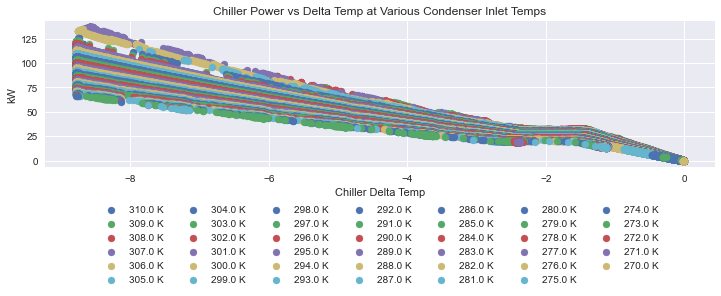

In [113]:
evaps_df['cond_inlet_K'] = evaps_df['cond_inlet'] + 273.15
evaps_df['cond_inlet_K_rounded'] = evaps_df['cond_inlet_K'].round()
cond_inlet_vals = evaps_df['cond_inlet_K_rounded'].unique()
cond_inlet_vals[::-1].sort()
print(len(cond_inlet_vals))
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot()   
for cond_inlet_v in cond_inlet_vals:
    cond_inlet_df = evaps_df[evaps_df['cond_inlet_K_rounded'] == cond_inlet_v]
    loop_inlets = []
    chiller_outlets = []
    chiller_diffs = []
    chiller_ps = []
    for n in range(1, 8):
        loop_inlets += cond_inlet_df[f'loop_inlet_{n}'].values.tolist()
        chiller_outlets += cond_inlet_df[f'chiller_outlet_{n}'].values.tolist()
        chiller_diffs += (cond_inlet_df[f'chiller_outlet_{n}'].values - cond_inlet_df[f'loop_inlet_{n}'].values).tolist()
        chiller_ps += cond_inlet_df[f'chiller_p_{n}'].values.tolist()
    ax.scatter(chiller_diffs, chiller_ps, label=f"{cond_inlet_v} K")
    # break
ax.set_xlabel('Chiller Delta Temp')
ax.set_ylabel('kW')
ax.set_title(f"Chiller Power vs Delta Temp at Various Condenser Inlet Temps")


# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=7)
plt.show()

[  0.22952657 -10.74753087] -66.41831443904562


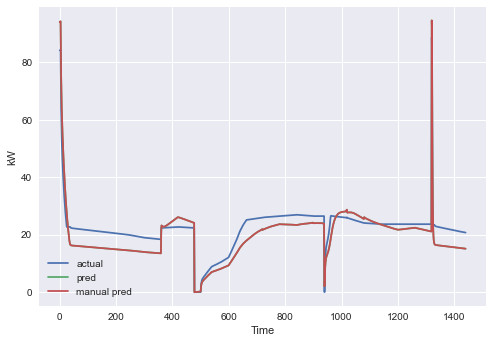

In [114]:
from sklearn import linear_model

# Try Linear Regression with Features = Condenser Inlet Temp and Evaporator Temp Difference

cond_inlets = []
chiller_diffs = []
chiller_ps = []
for n in range(1, 8):
    cond_inlets += (evaps_df[f'cond_inlet'].values + 273.15).tolist()
    chiller_diffs += (evaps_df[f'chiller_outlet_{n}'].values - evaps_df[f'loop_inlet_{n}'].values).tolist()
    chiller_ps += evaps_df[f'chiller_p_{n}'].values.tolist()

clf = linear_model.LinearRegression(fit_intercept=True)
clf.fit([i for i  in zip(cond_inlets, chiller_diffs)],
        chiller_ps)
print(clf.coef_, clf.intercept_)
clf.score([i for i  in zip(cond_inlets, chiller_diffs)],
        chiller_ps)

# with Celsius
# [  0.22952657 -10.74753087] -3.7231310972587863

# with Kelvin
# [  0.22952657 -10.74753087] -66.41831443904572

# Check performance for 1st day
X = np.array((evaps_short['cond_inlet'].values + 273.15, evaps_short['chiller_outlet_1'].values - evaps_short['loop_inlet_1'])).T
pred = clf.predict(X)

plt.plot(evaps_short["chiller_p_1"].values, label="actual")
plt.plot(pred, label="pred")
plt.plot(((evaps_short['cond_inlet'].values + 273.15) * 0.22952 - 10.747 * (evaps_short['chiller_outlet_1'].values - evaps_short['loop_inlet_1']) - 66.418).values, label="manual pred")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()

In [115]:
# tank_state.parquet from init_from_log.py

n_tanks = 1
thermal_tank_log_dir = controls_path / "schedules_mdoff" / "coned" / f"{n_tanks}tanks"
tank_states_file = thermal_tank_log_dir / "tank_states.parquet"

tank_states_df = pd.read_parquet(tank_states_file)
tank_states_df = tank_states_df.set_index(ix)
tank_states_df = pd.concat([tank_states_df, evaps_df], axis=1)
tank_states_df.drop(columns=[f"evap_diff_{n}" for n in range(2, 8)], inplace=True)
tank_states_df.drop(columns=[f"chiller_p_{n}" for n in range(2, 8)], inplace=True)
# tank_states_df.drop(columns=[f"bldg_elec_p_{n}" for n in range(2, 8)], inplace=True)
tank_states_df.drop(columns=[f"loop_inlet_{n}" for n in range(2, 8)], inplace=True)
tank_states_df.drop(columns=[f"loop_outlet_{n}" for n in range(2, 8)], inplace=True)
tank_states_df.drop(columns=[f"chiller_outlet_{n}" for n in range(2, 8)], inplace=True)
tank_states_df


,timestep,inlet_temp,outlet_temp,outlet_settemp,tank_temp,env_temp,tank_flow_fraction,soc,is_charging,op_mode,...,bldg_elec_p_1,bldg_elec_p_2,bldg_elec_p_3,bldg_elec_p_4,bldg_elec_p_5,bldg_elec_p_6,bldg_elec_p_7,cond_inlet,cond_inlet_K,cond_inlet_K_rounded
2019-01-01 00:01:00,24.016667,6.700000,9.890250,9.890250,14.939140,20,1.0,0.000000,1,1,...,17.904917,17.904917,17.904917,17.904917,17.904917,17.904917,17.904917,17.000000,290.150000,290.0
2019-01-01 00:02:00,24.033333,-1.186593,4.799389,4.799389,14.201583,20,1.0,0.000000,1,1,...,16.859901,16.859901,16.859901,16.859901,16.859901,16.859901,16.859901,17.000000,290.150000,290.0
2019-01-01 00:03:00,24.050000,-1.407274,4.387718,4.387718,13.487990,20,1.0,0.000000,1,1,...,16.859542,16.859542,16.859542,16.859542,16.859542,16.859542,16.859542,17.000000,290.150000,290.0
2019-01-01 00:04:00,24.066667,-2.702367,3.313148,3.313148,12.747947,20,1.0,0.000000,1,1,...,16.859542,16.859542,16.859542,16.859542,16.859542,16.859542,16.859542,17.000000,290.150000,290.0
2019-01-01 00:05:00,24.083333,-3.758068,2.378622,2.378622,11.993680,20,1.0,0.000000,1,1,...,16.859542,16.859542,16.859542,16.859542,16.859542,16.859542,16.859542,17.000000,290.150000,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:56:00,8783.933333,-3.800000,-2.463924,-2.463924,0.000000,20,1.0,0.390131,1,1,...,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,17.866667,291.016667,291.0
2019-12-31 23:57:00,8783.950000,-3.800000,-2.464645,-2.464645,0.000000,20,1.0,0.392080,1,1,...,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,17.900000,291.050000,291.0
2019-12-31 23:58:00,8783.966667,-3.800000,-2.465366,-2.465366,0.000000,20,1.0,0.394028,1,1,...,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,17.933333,291.083333,291.0
2019-12-31 23:59:00,8783.983333,-3.800000,-2.466087,-2.466087,0.000000,20,1.0,0.395976,1,1,...,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,21.326536,17.966667,291.116667,291.0


In [116]:
evaps_df['evap_diff'] = build_load_func[:, 1]
bldg_columns = ['bldg_elec_p_' + str(n) for n in range(1, 8)]
mean = evaps_df[bldg_columns].mean(axis=1)
evaps_df.drop(columns=bldg_columns, inplace=True)
evaps_df['bldg_elec_p'] = mean.values
evaps_df.drop(columns=['chiller_p_' + str(n) for n in range(1, 8)], inplace=True)
evaps_df.drop(columns=['evap_diff_' + str(n) for n in range(1, 8)], inplace=True)
# evaps_df.to_parquet(mpc_init_path)

In [117]:
base_bld = pd.read_parquet(controls_path / "schedules_mdoff" / "base.parquet")
base_bldg_load = (base_bld['ElectricityPurchased:Facility [J](TimeStep)'] - base_bld['EVLoad:ExteriorEquipment:Electricity [J](TimeStep)'])/ 1000 / 60
base_chiller_load = base_bld['CHW LOOP CHILLER:Chiller Electricity Energy [J](TimeStep)'] / 60 / 1000

new_bld = pd.read_parquet(controls_path / "schedules_mdoff" / "coned" / "1tanks" / 'eplusout.parquet')
new_chiller_load = new_bld['CHW LOOP CHILLER:Chiller Electricity Energy [J](TimeStep)'] / 60 / 1000
new_bldg_load = (new_bld['ElectricityPurchased:Facility [J](TimeStep)'] - new_bld['EVLoad:ExteriorEquipment:Electricity [J](TimeStep)'])/ 1000 / 60
chw_states_fixed = pd.read_parquet(controls_path / "schedules_mdoff/coned/1tanks/chw_states_fixed.parquet")
chw_states_fixed.set_index(pd.to_datetime(chw_states_fixed["DateTime"]), inplace=True)
len(chw_states_fixed.index)
chw_states_fixed.columns

Index(['DateTime', 'timestep', 'inlet_temp', 'outlet_temp', 'outlet_settemp',
       'tank_temp', 'env_temp', 'tank_flow_fraction', 'soc', 'is_charging',
       'op_mode', 'loop_inlet', 'chiller_outlet', 'evap_diff', 'chiller_power',
       'cond_inlet', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')

Text(0.5, 0, 'Time')

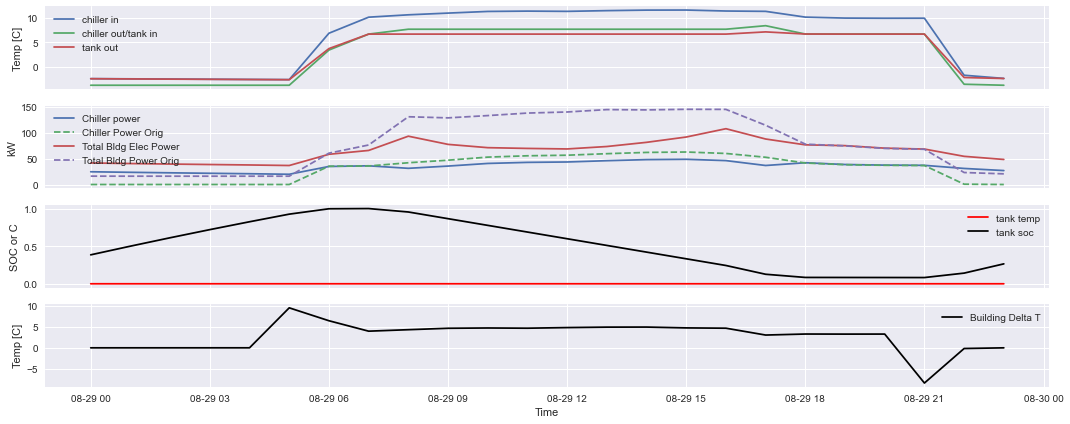

In [118]:
chw_states_fixed['bldg_elec_load'] = new_bldg_load.values
chw_states_fixed['bldg_elec_load_orig'] = base_bldg_load.values
chw_states_fixed['chiller_power_orig'] = base_chiller_load.values
chw_states_fixed['chiller_power_new'] = new_chiller_load.values


chw_states_hourly = chw_states_fixed.resample('60T').mean()
# chw_states_hourly = chw_states_fixed

evap_diffs = np.zeros(8761)
for i in range(1, 8761):
    evap_diffs[i] = chw_states_hourly['loop_inlet'][(i + 1) % 8760] - chw_states_hourly['outlet_settemp'][i]

chw_states_hourly['evap_diff'] = evap_diffs
steps_per_hr = 1
timesteps = 24 * steps_per_hr * 240
start = timesteps
end = start + 24 * steps_per_hr
fig, ax = plt.subplots(4, 1, figsize=(18,7), sharex=True)
ax[0].plot(chw_states_hourly['loop_inlet'][start:end], label="chiller in")
ax[0].plot(chw_states_hourly['inlet_temp'][start:end], label="chiller out/tank in")
ax[0].plot(chw_states_hourly['outlet_settemp'][start:end], label="tank out")
ax[0].legend()
ax[0].set_ylabel("Temp [C]")

ax[2].plot(chw_states_hourly['tank_temp'][start:end], 'r', label="tank temp")
ax[2].plot(chw_states_hourly['soc'][start:end], 'k', label="tank soc")
ax[2].legend()
ax[2].set_ylabel("SOC or C")

ax[1].plot(chw_states_hourly['chiller_power_new'][start:end], label="Chiller power")
ax[1].plot(chw_states_hourly['chiller_power_orig'][start:end], linestyle='dashed', label="Chiller Power Orig")
ax[1].plot(chw_states_hourly['bldg_elec_load'][start:end], label="Total Bldg Elec Power")
ax[1].plot(chw_states_hourly['bldg_elec_load_orig'][start:end], linestyle='dashed', label="Total Bldg Power Orig")
ax[1].legend()
ax[1].set_ylabel("kW")

ax[3].plot(chw_states_hourly['evap_diff'][start:end], 'k', label="Building Delta T")
ax[3].legend()
ax[3].set_ylabel("Temp [C]")
ax[3].set_xlabel("Time")

# chw_states_hourly.to_csv(controls_path / "schedules_mdoff/coned/1tanks/chw_states_hourly.csv")

In [119]:
from sklearn import linear_model

cond_inlets = []
chiller_diffs = []
chiller_ps = []
cond_inlets = (chw_states_hourly[f'cond_inlet'].values + 273.15).tolist()
chiller_diffs = (chw_states_hourly[f'inlet_temp'].values - chw_states_hourly[f'loop_inlet'].values).tolist()
chiller_ps = chw_states_hourly[f'chiller_power'].values.tolist()

clf = linear_model.LinearRegression(fit_intercept=True)
clf.fit([i for i  in zip(cond_inlets, chiller_diffs)],
        chiller_ps)
print(clf.coef_, clf.intercept_)
clf.score([i for i  in zip(cond_inlets, chiller_diffs)],
        chiller_ps)

# [ 0.35750133 -9.7829402 ] -100.14402057970096
# 0.9502327082864163

[ 0.35750133 -9.7829402 ] -100.14402057970132


0.9502327082864163

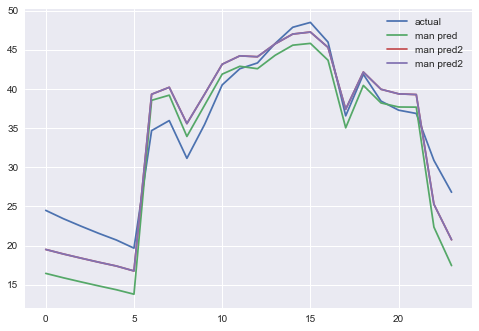

In [120]:
pred_1 = ((chw_states_hourly['cond_inlet'].values + 273.15) * 0.22952 - 10.747 * (chw_states_hourly['inlet_temp'].values - chw_states_hourly['loop_inlet']) - 66.418).values
pred_2 = ((chw_states_hourly['cond_inlet'].values + 273.15) * 0.35750133 - 9.7829402 * (chw_states_hourly['inlet_temp'].values - chw_states_hourly['loop_inlet']) - 100.1440205).values

plt.plot(chw_states_hourly["chiller_power"].values[start:end], label="actual")
plt.plot(pred_1[start:end], label="man pred")

plt.plot(pred_2[start:end], label="man pred2")
plt.plot(pred_2[start:end], label="man pred2")
plt.legend()

chw_states_hourly['chiller_power_pred'] = pred_2
# chw_states_hourly.to_parquet(controls_path / "schedules_mdoff/coned/1tanks/chw_states_hourly.parquet")


# Create Initial TES MPC States from Log files

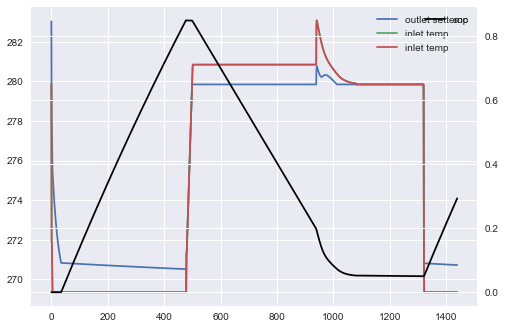

In [121]:
# tank_state.parquet from init_from_log.py

df_states = pd.read_parquet(controls_path / "schedules_mdoff/coned/1tanks/tank_states.parquet")
plt.plot(df_states['outlet_settemp'].values[0:1440] + 273.15, label="outlet settemp")
plt.plot(df_states['inlet_temp'].values[0:1440] + 273.15, label="inlet temp")
plt.plot(df_states['inlet_temp'].values[0:1440] + 273.15, label="inlet temp")
plt.legend()
ax = plt.twinx()
ax.plot(df_states['soc'].values[0:1440], label='soc', color='k')
plt.legend()

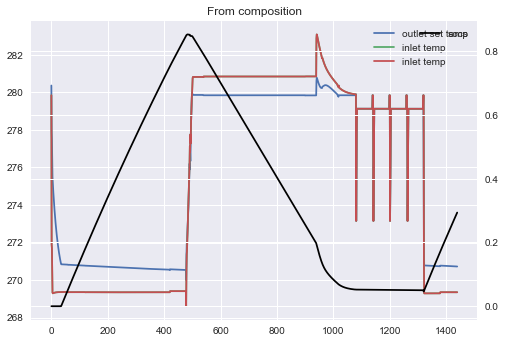

In [122]:
# Get tank states for 1 tank from mpc init_from_log
n_tanks = 1
thermal_tank_log_dir = controls_path / "schedules_mdoff" / "coned" / f"{n_tanks}tanks"
with open(thermal_tank_log_dir / "solution_60.json", 'r') as f:
    mpc_tank = json.load(f)
mpc_df = pd.DataFrame(index=ix)

mpc_vars = set()
for name in mpc_tank['0'].keys():
    if 'diff_sum' in name:
        continue
    mpc_vars.add(name.split('[')[0])
mpc_data = {}
for name in mpc_vars:
    mpc_data[name] = []

for start_time in mpc_tank.keys():
    start_time_int = int(start_time)
    for k, v in mpc_tank[start_time].items():
        name = k.split('[')[0]
        if 'diff_sum' in name:
            continue
        if '[-1]' in k:
            continue
        mpc_data[name].append(v)
max_len = len(mpc_data[name])
new_sol = {}
for d in range(365):
    ts = d * 1440
    dat = {}
    if ts + 1440 > max_len - 1:
        break
    for name in mpc_vars:
        for i in range(1440):
            name_ts = f"{name}[{i}]"
            val = mpc_data[name][ts + i]
            dat[name_ts] = val
    new_sol[str(ts)] = dat
with open(thermal_tank_log_dir / "solution_1440.json", 'w') as f:
    json.dump(new_sol, f)

mpc_data.keys()
socs = [1. - i / (2 * 1e-2) for i in mpc_data['tank_temp_d2']]
plt.plot(mpc_data['outlet_settemp'][0:1440], label='outlet set temp')
plt.plot(mpc_data['inlet_temp'][0:1440], label='inlet temp')
plt.plot(mpc_data['inlet_temp'][0:1440], label='inlet temp')
plt.legend()
ax = plt.twinx()
ax.plot(socs[0:1440], label='socs', color='k')
plt.legend()
plt.title("From composition")

plt.show()


In [123]:
import glob
ev_load_dir = Path("/projects/enstore/EVI-EnSite-to-EVI-EDGES/data/_06_medium_office")

ev_loads = {}
for load in glob.glob(str(ev_load_dir / "*.csv")):
    name_arr = Path(load).stem.split('_')
    nports = name_arr[1]
    nevents = name_arr[2]
    chrglevel = name_arr[3]
    df_ev = pd.read_csv(load, parse_dates=True, index_col=0)
    ev_load = df_ev["Port 1 [W]"].div(1000)
    ev_loads[f"{nports}_{nevents}_{chrglevel}"] = ev_load.values


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


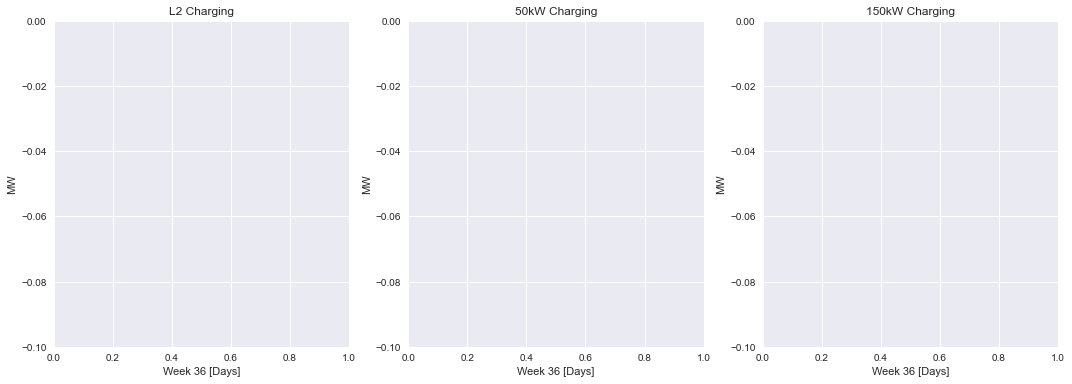

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

start_day = 252
start_plot = start_day * 1440
end_plot = start_plot + 1440 * 1
max_kw = 0
for k, v in ev_loads.items():

    name_arr = k.split('_')
    nports = name_arr[0]
    nevents = name_arr[1]
    chrglevel = name_arr[2]
    plot_v = [i * 1e-3 for i in v[start_plot:end_plot]]
    xvals = [i / 1440 for i in range(len(plot_v))]
    if chrglevel == '7.2':
        ax[0].plot(xvals, plot_v, label=f"L2 {nports} Port {nevents} Event")
    elif chrglevel == '50.0':
        ax[1].plot(xvals, plot_v, label=f"50kW {nports} Port {nevents} Event")
    else:
        ax[2].plot(xvals, plot_v, label=f"150kW {nports} Port {nevents} Event")
    max_kw = max(max_kw, max(plot_v))
ax[0].set_title("L2 Charging")
ax[0].set_ylim((-0.1, max_kw * 1.1))
ax[0].set_xlabel(f"Week {int(start_day / 7)} [Days]")
ax[0].set_ylabel("MW")
ax[0].legend()
ax[1].set_title("50kW Charging")
ax[1].set_ylim((-0.1, max_kw * 1.1))
ax[1].set_xlabel(f"Week {int(start_day / 7)} [Days]")
ax[1].set_ylabel("MW")
ax[1].legend()
ax[2].set_title("150kW Charging")
ax[2].set_ylim((-0.1, max_kw * 1.1))
ax[2].set_xlabel(f"Week {int(start_day / 7)} [Days]")
ax[2].set_ylabel("MW")
ax[2].legend()




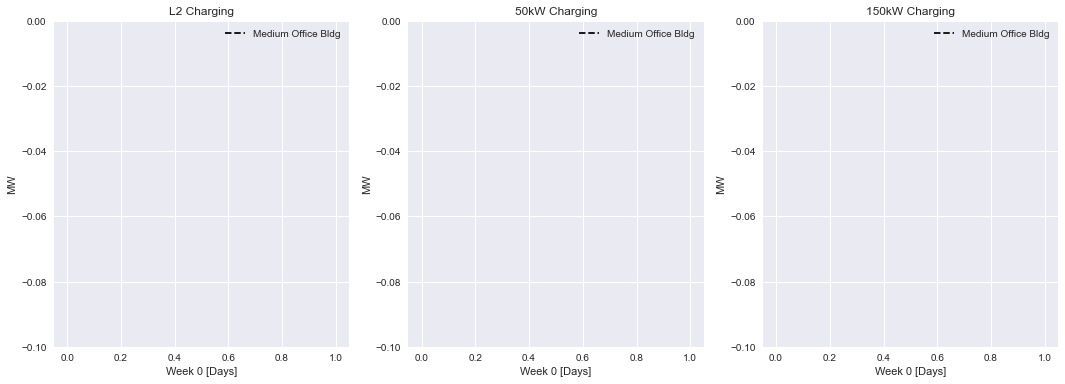

In [125]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

start_day = 0
start_plot = start_day * 1440
end_plot = start_plot + 1440 * 1
max_kw = 0
plot_b = [i * 1e-3 for i in base_bldg_load[start_plot:end_plot]]
xvals = [i / 1440 for i in range(len(plot_b))]

ax[0].plot(xvals, plot_b, 'k', linestyle='dashed', label="Medium Office Bldg")
ax[1].plot(xvals, plot_b, 'k', linestyle='dashed', label="Medium Office Bldg")
ax[2].plot(xvals, plot_b, 'k', linestyle='dashed', label="Medium Office Bldg")
for k, v in ev_loads.items():

    name_arr = k.split('_')
    nports = name_arr[0]
    nevents = name_arr[1]
    chrglevel = name_arr[2]
    plot_v = [i * 1e-3 for i in v[start_plot:end_plot]]
    plot_v = [i + j for i, j in zip(plot_v, plot_b)]
    if chrglevel == '7.2':
        ax[0].plot(xvals, plot_v, label=f"L2 {nports} Port {nevents} Event")
    elif chrglevel == '50.0':
        ax[1].plot(xvals, plot_v, label=f"50kW {nports} Port {nevents} Event")
    else:
        ax[2].plot(xvals, plot_v, label=f"150kW {nports} Port {nevents} Event")
    max_kw = max(max_kw, max(plot_v))
ax[0].set_title("L2 Charging")
ax[0].set_ylim((-0.1, max_kw * 1.1))
ax[0].set_xlabel(f"Week {int(start_day / 7)} [Days]")
ax[0].set_ylabel("MW")
ax[0].legend()
ax[1].set_title("50kW Charging")
ax[1].set_ylim((-0.1, max_kw * 1.1))
ax[1].set_xlabel(f"Week {int(start_day / 7)} [Days]")
ax[1].set_ylabel("MW")
ax[1].legend()
ax[2].set_title("150kW Charging")
ax[2].set_ylim((-0.1, max_kw * 1.1))
ax[2].set_xlabel(f"Week {int(start_day / 7)} [Days]")
ax[2].set_ylabel("MW")
ax[2].legend()


